# Whale stalker, whale saver
Explanatory data analsysis for the dataset of the challenge

In [2]:
import os
import pandas as pd
import numpy as np
import cv2

import torch
from torch import nn, optim
from torch.optim import lr_scheduler

import torchvision.transforms as transforms
from torchvision import datasets, models
from PIL import Image

from skimage import io, transform

In [2]:
data_folder = os.path.join('..', 'data/')
img_train_path = os.path.abspath(data_folder+'train')
img_test_path = os.path.abspath(data_folder+'test')
csv_train_path = os.path.abspath(data_folder+'train.csv')

df = pd.read_csv(csv_train_path)
# create image path to simplify the image reading process 
df['Image_path'] = [os.path.join(img_train_path,whale) for whale in df['Image']]

In [3]:
print(f"Number of images: {df.shape[0]}")
print(f"Number of unique species: {df.Id.nunique()}")
print(df.head())
df.Id.value_counts().head()

Number of images: 25361
Number of unique species: 5005
           Image         Id                                         Image_path
0  0000e88ab.jpg  w_f48451c  /Users/rachaelsaxby/Desktop/fg-hackathon/kaggl...
1  0001f9222.jpg  w_c3d896a  /Users/rachaelsaxby/Desktop/fg-hackathon/kaggl...
2  00029d126.jpg  w_20df2c5  /Users/rachaelsaxby/Desktop/fg-hackathon/kaggl...
3  00050a15a.jpg  new_whale  /Users/rachaelsaxby/Desktop/fg-hackathon/kaggl...
4  0005c1ef8.jpg  new_whale  /Users/rachaelsaxby/Desktop/fg-hackathon/kaggl...


new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

## Display a few samples

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

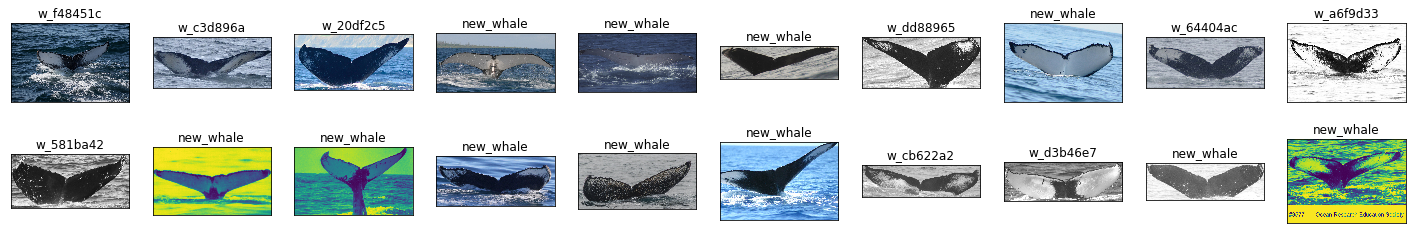

In [5]:
# Display a few examples
classes_to_display = 20

fig = plt.figure(figsize=(25, 4))
for idx in range(classes_to_display):
    img_name = df.Image.iloc[idx]
    img_label = df.Id.iloc[idx]
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = mpimg.imread(os.path.join(data_folder, 'train', img_name))
    plt.imshow(img)
    ax.set_title(img_label)    

In [104]:
# transforms
train_transforms = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomAffine(15, translate=None, scale=None, shear=15, resample=False, fillcolor=0),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])    
  ])

In [7]:
# get a sample of 20 whales
sample = np.random.choice(df['Image'],20)
file_path_sample = [os.path.join(img_train_path,whale) for whale in sample]

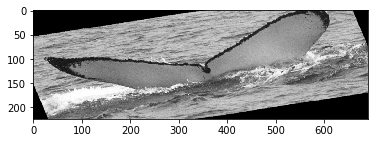

In [8]:
# apply transforms to sample images
imgs = [Image.open(whale) for whale in file_path_sample]
imgs_tensor = [train_transforms(whale) for whale in imgs]

# display a sample
img = imgs_tensor[0]
plt.imshow(img[0],cmap='gray')
plt.show()


In [9]:
# prepare the transformed images to be passed to model
train = df['Image_path'][:100] # prepare small sequence to test the process
imgs = [Image.open(whale) for whale in train]
imgs_tensor = [train_transforms(whale) for whale in imgs]

In [10]:
# create a df which excludes new_whale
exclude_new_whale = df['Id']!= 'new_whale'
exclude_new_whale_df = df[exclude_new_whale]
exclude_new_whale_df.Id.value_counts().head()

w_23a388d    73
w_9b5109b    65
w_9c506f6    62
w_0369a5c    61
w_700ebb4    57
Name: Id, dtype: int64

In [67]:
# class to create a custom dataset
'''class Dataset:
    def __init__(self, csv_path, img_path, transform=None):
        """
        csv_path: path to csv file
        img_path: path to the image folder
        transform: torch transforms
        """
        # Transforms
        self.transforms = transform
        # Image folder path
        self.img_path = img_path
        # Ceate df from csv file
        self.data = pd.read_csv(csv_path)
        # Create array of images
        self.images = self.data.iloc[:, 0]
        # Creat array of labels
        self.labels = self.data.iloc[:, 1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Get image name from df
        image_name = os.path.join(self.img_path,
                               self.images[index])
        
        # Open image
        img = Image.open(image_name)
        # Transform image
        if self.transforms:
            img = self.transforms(img)
        # Get labels
        label = self.labels[idx]
        sample = {'image': img, 'label': label}

        
        return sample'''

In [105]:
# create a dataset
dataset = Dataset(csv_path=csv_train_path, img_path=img_train_path, transform=train_transforms )

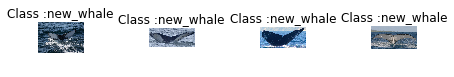

In [98]:
# display some samples
fig = plt.figure()

for i in range(4):
    sample = dataset[i]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Class :{}'.format(sample['label']))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

In [111]:
# define data loader
train_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=10,shuffle=True)

0 torch.Size([10, 1, 224, 224]) ['new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale']
1 torch.Size([10, 1, 224, 224]) ['new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale']
2 torch.Size([10, 1, 224, 224]) ['new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale']
3 torch.Size([10, 1, 224, 224]) ['new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale', 'new_whale']


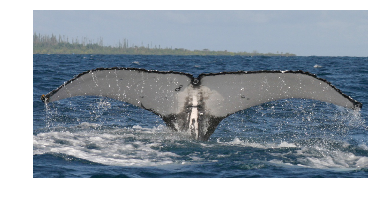

In [110]:
# print a sample
for idx_batch, batch in enumerate(train_dataloader):
    print(idx_batch, batch['image'].size(),
          batch['label'])

    # observe 4th batch and stop.
    if idx_batch == 3:
        plt.figure()
        plt.imshow(sample['image'])
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [3]:
model = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/paul/.torch/models/resnet34-333f7ec4.pth
100.0%


In [4]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
for param in model.parameters():
    param.requires_grad = False

In [6]:
model.classifier = nn.Sequential(nn.Linear(512,1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024,2048),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(2048,5005),
                                 nn.LogSoftmax(dim=1))

In [8]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.1,last_epoch=-1)
epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
from trainer import train_model
trained_model = train_model(model=model,
                            criteria=criterion,
                            optimizer=optimizer,
                            scheduler=scheduler,
                            num_epochs=epochs,
                            device=device)

NameError: name 'copy' is not defined